# **PR0502. Manipulación básica de dataframes**

In [19]:
from pyspark.sql import SparkSession

try:
    spark = ( SparkSession.builder
    .appName("Haciendo pruebas")
    .master("spark://spark-master:7077")
    .getOrCreate()
    )

    print("SparkSession iniciada correctamente.")
except Exception as e:
    print("Error en la conexión")
    print(e)

SparkSession iniciada correctamente.


## **Dataset 1: Datos para la predicción del rendimiento en cultivos**

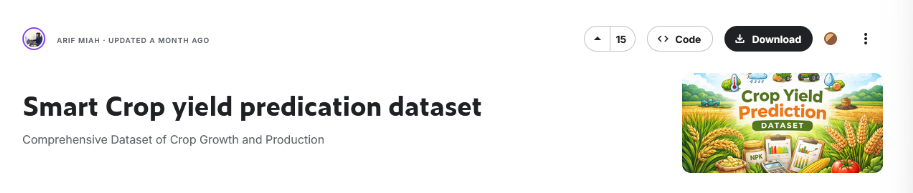

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit

schema = StructType([
    StructField("Crop",StringType(),True),
    StructField("Region",StringType(),True),
    StructField("Soil_Type",StringType(),True),
    StructField("Soil_pH",DoubleType(),True),
    StructField("Rainfall_mm",DoubleType(),True),
    StructField("Temperature_C",DoubleType(),True),
    StructField("Humidity_pct",DoubleType(),True),
    StructField("Fertilizer_Used_kg",DoubleType(),True),
    StructField("Irrigation",StringType(),True),
    StructField("Pesticides_Used_kg",DoubleType(),True),
    StructField("Planting_Density",DoubleType(),True),
    StructField("Previous_Crop",StringType(),True),
    StructField("Yield_ton_per_ha",DoubleType(),True)
])

df_cultivos = (spark.read
    .format("csv")
    .schema(schema)
    .option("header", "true")
    .option("quote", "\"")
    .load("./crop_yield_dataset.csv")
)

df_cultivos.printSchema()

root
 |-- Crop: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Soil_pH: double (nullable = true)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_C: double (nullable = true)
 |-- Humidity_pct: double (nullable = true)
 |-- Fertilizer_Used_kg: double (nullable = true)
 |-- Irrigation: string (nullable = true)
 |-- Pesticides_Used_kg: double (nullable = true)
 |-- Planting_Density: double (nullable = true)
 |-- Previous_Crop: string (nullable = true)
 |-- Yield_ton_per_ha: double (nullable = true)



### **1.- Selección de características**

Crea un nuevo DataFrame llamado ``df_sel`` que contenga únicamente las columnas: ``Crop``, ``Region``, ``Temperature_C``, ``Rainfall_mm``, ``Irrigation`` y ``Yield_ton_per_ha``.

In [4]:
from pyspark.sql import functions as F

df_sel = df_cultivos.select(
    "Crop",
    "Region",
    "Temperature_C",
    "Rainfall_mm",
    "Irrigation",
    "Yield_ton_per_ha"
)

df_sel.show(5)

26/01/24 11:49:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------+--------+-------------+-----------+----------+----------------+
|  Crop|  Region|Temperature_C|Rainfall_mm|Irrigation|Yield_ton_per_ha|
+------+--------+-------------+-----------+----------+----------------+
| Maize|Region_C|         19.7|     1485.4|      Drip|          101.48|
|Barley|Region_D|         29.1|      399.4| Sprinkler|          127.39|
|  Rice|Region_C|         30.5|      980.9| Sprinkler|           68.99|
| Maize|Region_D|         26.4|     1054.3|      Drip|          169.06|
| Maize|Region_D|         20.4|      744.6|      Drip|          118.71|
+------+--------+-------------+-----------+----------+----------------+
only showing top 5 rows



### **2.- Normalización de nombres**

Los nombres actuales son muy largos y técnicos (tienen unidades). Necesitamos estandarizarlos al español o simplificarlos. Usando el DataFrame ``df_sel`` del ejercicio anterior, cambia los siguientes nombres:
- ``Temperature_C`` -> ``Temperatura``
- ``Rainfall_mm`` -> ``Lluvia``
- ``Yield_ton_per_ha`` -> ``Rendimiento``
  
Guarda el resultado en ``df_renamed``.

In [5]:
df_renamed = (df_sel
    .withColumnRenamed("Temperature_C", "Temperatura")
    .withColumnRenamed("Rainfall_mm", "Lluvia")
    .withColumnRenamed("Yield_ton_per_ha", "Rendimiento")
)

df_renamed.printSchema()
df_renamed.show(5)

root
 |-- Crop: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Temperatura: double (nullable = true)
 |-- Lluvia: double (nullable = true)
 |-- Irrigation: string (nullable = true)
 |-- Rendimiento: double (nullable = true)

+------+--------+-----------+------+----------+-----------+
|  Crop|  Region|Temperatura|Lluvia|Irrigation|Rendimiento|
+------+--------+-----------+------+----------+-----------+
| Maize|Region_C|       19.7|1485.4|      Drip|     101.48|
|Barley|Region_D|       29.1| 399.4| Sprinkler|     127.39|
|  Rice|Region_C|       30.5| 980.9| Sprinkler|      68.99|
| Maize|Region_D|       26.4|1054.3|      Drip|     169.06|
| Maize|Region_D|       20.4| 744.6|      Drip|     118.71|
+------+--------+-----------+------+----------+-----------+
only showing top 5 rows



### **3.- Filtrado de datos (filter)**

Supón que queremos centrarnos en cultivos de maíz que han crecido en regiones calurosas (más de 25 grados). Filtra ``df_renamed`` para mantener solo las filas donde:
- El cultivo (``Crop``) sea igual a “Maize”.
- La temperatura (``Temperatura``) sea mayor a 25.

In [6]:
df_filtrado = df_renamed.filter(
    (F.col("Crop") == "Maize") & (F.col("Temperatura") > 25)
)

df_filtrado.show(10)

+-----+--------+-----------+------+----------+-----------+
| Crop|  Region|Temperatura|Lluvia|Irrigation|Rendimiento|
+-----+--------+-----------+------+----------+-----------+
|Maize|Region_D|       26.4|1054.3|      Drip|     169.06|
|Maize|Region_C|       32.4| 846.1|      None|      162.2|
|Maize|Region_A|       26.6| 362.5| Sprinkler|      95.23|
|Maize|Region_C|       33.7|1193.3|      None|     110.57|
|Maize|Region_C|       27.8| 695.2|     Flood|     143.84|
|Maize|Region_D|       30.2|1001.4|     Flood|     138.61|
|Maize|Region_A|       27.7| 747.7| Sprinkler|     114.58|
|Maize|Region_B|       28.9|1392.9|      Drip|     169.23|
|Maize|Region_B|       34.7| 694.4|      Drip|      96.08|
|Maize|Region_D|       29.5| 848.8|     Flood|      93.45|
+-----+--------+-----------+------+----------+-----------+
only showing top 10 rows



### **4.- Encadenamiento**

En Spark podemos **encadenar** varias funciones. Repite las órdenes anteriores encadenadas en una única sentencia

In [7]:
from pyspark.sql import functions as F

df_final = (
    df_cultivos
    .select("Crop", "Region", "Temperature_C", "Rainfall_mm", "Irrigation", "Yield_ton_per_ha")
    .withColumnRenamed("Temperature_C", "Temperatura")
    .withColumnRenamed("Rainfall_mm", "Lluvia")
    .withColumnRenamed("Yield_ton_per_ha", "Rendimiento")
    .filter((F.col("Crop") == "Maize") & (F.col("Temperatura") > 25))
)

df_final.show(10)

+-----+--------+-----------+------+----------+-----------+
| Crop|  Region|Temperatura|Lluvia|Irrigation|Rendimiento|
+-----+--------+-----------+------+----------+-----------+
|Maize|Region_D|       26.4|1054.3|      Drip|     169.06|
|Maize|Region_C|       32.4| 846.1|      None|      162.2|
|Maize|Region_A|       26.6| 362.5| Sprinkler|      95.23|
|Maize|Region_C|       33.7|1193.3|      None|     110.57|
|Maize|Region_C|       27.8| 695.2|     Flood|     143.84|
|Maize|Region_D|       30.2|1001.4|     Flood|     138.61|
|Maize|Region_A|       27.7| 747.7| Sprinkler|     114.58|
|Maize|Region_B|       28.9|1392.9|      Drip|     169.23|
|Maize|Region_B|       34.7| 694.4|      Drip|      96.08|
|Maize|Region_D|       29.5| 848.8|     Flood|      93.45|
+-----+--------+-----------+------+----------+-----------+
only showing top 10 rows



## **Dataset 2: Lugares famosos del mundo**

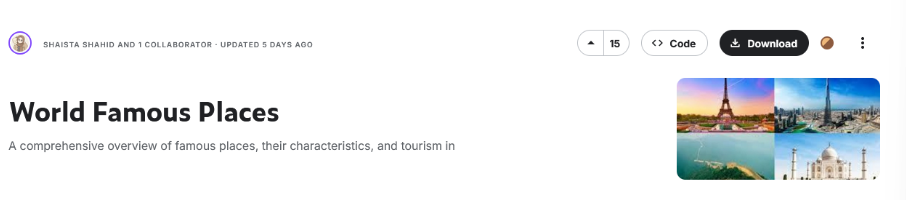

In [8]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType 
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit

schema = StructType([
    StructField("Place_Name", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Annual_Visitors_Millions", DoubleType(), True),
    StructField("Type", StringType(), True),
    StructField("UNESCO_World_Heritage", StringType(), True), 
    StructField("Year_Built", IntegerType(), True),
    StructField("Entry_Fee_USD", DoubleType(), True),
    StructField("Best_Visit_Month", StringType(), True),
    StructField("Tourism_Revenue_Million_USD", DoubleType(), True),
    StructField("Average_Visit_Duration_Hours", DoubleType(), True),
    StructField("Famous_For", StringType(), True),
])

df_lugares = (spark.read
    .format("csv")
    .schema(schema)
    .option("header", "true")
    .option("quote", "\"")
    .load("./world_famous_places_2024.csv")
)

df_lugares.printSchema()

df_lugares.show(5)

root
 |-- Place_Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Annual_Visitors_Millions: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- UNESCO_World_Heritage: string (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Entry_Fee_USD: double (nullable = true)
 |-- Best_Visit_Month: string (nullable = true)
 |-- Tourism_Revenue_Million_USD: double (nullable = true)
 |-- Average_Visit_Duration_Hours: double (nullable = true)
 |-- Famous_For: string (nullable = true)

+-------------------+-------------+----------------+------------------------+------------------+---------------------+----------+-------------+-----------------+---------------------------+----------------------------+----------+
|         Place_Name|      Country|            City|Annual_Visitors_Millions|              Type|UNESCO_World_Heritage|Year_Built|Entry_Fee_USD| Best_Visit_Month|Tourism_Revenue_Million_USD|Average_Visit_Du

### **1.- Selección de datos críticos**

El dataset tiene mucha información descriptiva que no necesitamos para el análisis cuantitativo (como ``Famous_For`` o ``Best_Visit_Month``).

Crea un nuevo DataFrame llamado df_base seleccionando únicamente: ``Place_Name``, ``Country``, ``UNESCO_World_Heritage``, ``Entry_Fee_USD`` y ``Annual_Visitors_Millions``.

In [9]:
from pyspark.sql import functions as F

df_base = df_lugares.select(
    "Place_Name",
    "Country",
    "UNESCO_World_Heritage",
    "Entry_Fee_USD",
    "Annual_Visitors_Millions",
)

df_base.show(5)

+-------------------+-------------+---------------------+-------------+------------------------+
|         Place_Name|      Country|UNESCO_World_Heritage|Entry_Fee_USD|Annual_Visitors_Millions|
+-------------------+-------------+---------------------+-------------+------------------------+
|       Eiffel Tower|       France|                   No|         35.0|                     7.0|
|       Times Square|United States|                   No|          0.0|                    50.0|
|      Louvre Museum|       France|                  Yes|         22.0|                     8.7|
|Great Wall of China|        China|                  Yes|         10.0|                    10.0|
|          Taj Mahal|        India|                  Yes|         15.0|                     7.5|
+-------------------+-------------+---------------------+-------------+------------------------+
only showing top 5 rows



### **2.- Traducción y simplificación**

Las columnas tienen nombres en inglés y son demasiado largos para los reportes en español. Sobre el DataFrame ``df_base``, renombra las columnas de la siguiente manera y guarda el resultado en ``df_es``:
- ``Place_Name`` -> ``Lugar``
- ``UNESCO_World_Heritage`` -> ``Es_UNESCO``
- ``Entry_Fee_USD`` -> ``Precio_Entrada``
- ``Annual_Visitors_Millions`` -> ``Visitantes_Millones``

In [10]:
df_es = (df_base
    .withColumnRenamed("Place_Name", "Lugar")
    .withColumnRenamed("UNESCO_World_Heritage", "Es_UNESCO")
    .withColumnRenamed("Entry_Fee_USD", "Precio_Entrada")
    .withColumnRenamed("Annual_Visitors_Millions", "Visitantes_Millones")
)

df_es.printSchema()
df_es.show(5)

root
 |-- Lugar: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Es_UNESCO: string (nullable = true)
 |-- Precio_Entrada: double (nullable = true)
 |-- Visitantes_Millones: double (nullable = true)

+-------------------+-------------+---------+--------------+-------------------+
|              Lugar|      Country|Es_UNESCO|Precio_Entrada|Visitantes_Millones|
+-------------------+-------------+---------+--------------+-------------------+
|       Eiffel Tower|       France|       No|          35.0|                7.0|
|       Times Square|United States|       No|           0.0|               50.0|
|      Louvre Museum|       France|      Yes|          22.0|                8.7|
|Great Wall of China|        China|      Yes|          10.0|               10.0|
|          Taj Mahal|        India|      Yes|          15.0|                7.5|
+-------------------+-------------+---------+--------------+-------------------+
only showing top 5 rows



### **3.- Filtrado**

Supón que vamos a realizar una campaña y necesitamos filtrar los destinos que cumplan dos condiciones estrictas. Filtra ``df_es`` para obtener solo los registros que cumplan:
1. Sean Patrimonio de la Humanidad (``Es_UNESCO`` es igual a “Yes”).
2. El precio de entrada (``Precio_Entrada``) sea menor o igual a **20 dólares**.

In [11]:
df_filtrado2 = df_es.filter(
    (F.col("Es_UNESCO") == "Yes") & (F.col("Precio_Entrada") <= 20)
)

df_filtrado2.show(10)

+--------------------+--------------+---------+--------------+-------------------+
|               Lugar|       Country|Es_UNESCO|Precio_Entrada|Visitantes_Millones|
+--------------------+--------------+---------+--------------+-------------------+
| Great Wall of China|         China|      Yes|          10.0|               10.0|
|           Taj Mahal|         India|      Yes|          15.0|                7.5|
|           Colosseum|         Italy|      Yes|          18.0|               7.65|
|      Forbidden City|         China|      Yes|           8.0|                9.0|
|Notre-Dame Cathedral|        France|      Yes|           0.0|               13.0|
|Great Pyramid of ...|         Egypt|      Yes|          20.0|                2.8|
|Leaning Tower of ...|         Italy|      Yes|          20.0|                5.0|
|           Acropolis|        Greece|      Yes|          13.0|                4.0|
|             Big Ben|United Kingdom|      Yes|           0.0|                5.5|
+---

## **Dataset 3: Registro turístico de Castilla y León**

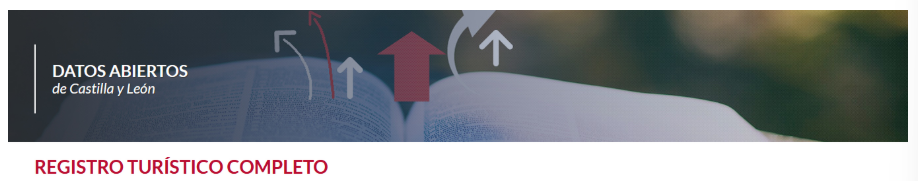

In [20]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, BooleanType, LongType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit

schema = StructType([
    StructField("establecimiento",StringType(),True),
    StructField("n_registro",StringType(),True),
    StructField("codigo",StringType(),True),
    StructField("tipo",StringType(),True),
    StructField("categoria",StringType(),True),
    StructField("especialidades",StringType(),True),
    StructField("clase",StringType(),True),
    StructField("nombre",StringType(),True),
    StructField("direccion",StringType(),True),
    StructField("c_postal",IntegerType(),True),
    StructField("provincia",StringType(),True),
    StructField("municipio",StringType(),True),
    StructField("localidad",StringType(),True),
    StructField("nucleo",StringType(),True),
    StructField("telefono_1",LongType(),True),
    StructField("telefono_2",LongType(),True),
    StructField("telefono_3",LongType(),True),
    StructField("email",StringType(),True),
    StructField("web",StringType(),True),
    StructField("q_calidad",StringType(),True),
    StructField("posada_real",StringType(),True),
    StructField("plazas",IntegerType(),True),
    StructField("gps_longitud",DoubleType(),True),
    StructField("gps_latitud",DoubleType(),True),
    StructField("accesible_a_personas_con_discapacidad",StringType(),True),
    StructField("column_27",StringType(),True),
    StructField("posicion",StringType(),True),

])
df_turistico = (spark.read
        .format("csv")
        .option("header","true")
        .option("sep",";")
        .schema(schema)
        .load("./registro-de-turismo-de-castilla-y-leon.csv")
     )

df_turistico.show(5)


[Stage 0:>                                                          (0 + 1) / 1]

+--------------------+----------+------+--------------------+---------------+--------------+-----+--------------------+--------------------+--------+---------+---------+---------------+---------------+----------+----------+----------+--------------------+--------------------+---------+-----------+------+------------+-----------+-------------------------------------+---------+--------------------+
|     establecimiento|n_registro|codigo|                tipo|      categoria|especialidades|clase|              nombre|           direccion|c_postal|provincia|municipio|      localidad|         nucleo|telefono_1|telefono_2|telefono_3|               email|                 web|q_calidad|posada_real|plazas|gps_longitud|gps_latitud|accesible_a_personas_con_discapacidad|column_27|            posicion|
+--------------------+----------+------+--------------------+---------------+--------------+-----+--------------------+--------------------+--------+---------+---------+---------------+---------------

### **1.- Selección y saneamiento**

Las columnas originales como ``N.Registro`` o ``GPS.Latitud`` tienen puntos, lo cual suele dar problemas en motores SQL o al guardar en Parquet. Además, solo necesitamos datos de contacto.

Crea un ``df_contactos`` seleccionando únicamente: ``Nombre``, ``Tipo``, ``Provincia``, ``web`` y ``Email``.

In [22]:
from pyspark.sql import functions as F

df_contactos = df_turistico.select(
    "Nombre",
    "Tipo",
    "Provincia",
    "web",
    "Email",
)

df_contactos.show(5)

+--------------------+--------------------+---------+--------------------+--------------------+
|              Nombre|                Tipo|Provincia|                 web|               Email|
+--------------------+--------------------+---------+--------------------+--------------------+
|BERNARDO MORO MEN...|Profesional de Tu...| Asturias|                NULL|bernardomoro@hotm...|
|        LA SASTRERÍA|Casa Rural de Alq...|    Ávila|www.lasastreriade...|                NULL|
|         LAS HAZANAS|Casa Rural de Alq...|    Ávila|                NULL|lashazanas@hotmai...|
| LA CASITA DEL PAJAR|Casa Rural de Alq...|    Ávila|                NULL|lashazanas@hotmai...|
|            MARACANA|                 Bar|    Ávila|                NULL|emo123anatoliev@g...|
+--------------------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



### **2.- Renombrado estándar**

Vamos a renombrar las columnas para que estén en minúsculas y no tengan ambigüedades

- ``Nombre`` ``nombre_establecimiento``
- ``Tipo`` ``categoria_actividad``
- ``web`` ``sitio_web``
- ``Email`` ``correo_electronico``

Guarda el resultado en ``df_limpio``.

In [23]:
df_limpio = (df_contactos
    .withColumnRenamed("Nombre", "nombre_establecimiento")
    .withColumnRenamed("Tipo", "categoria_actividad")
    .withColumnRenamed("web", "sitio_web")
    .withColumnRenamed("Email", "correo_electronico")
)

df_limpio.printSchema()
df_limpio.show(5)

root
 |-- nombre_establecimiento: string (nullable = true)
 |-- categoria_actividad: string (nullable = true)
 |-- Provincia: string (nullable = true)
 |-- sitio_web: string (nullable = true)
 |-- correo_electronico: string (nullable = true)

+----------------------+--------------------+---------+--------------------+--------------------+
|nombre_establecimiento| categoria_actividad|Provincia|           sitio_web|  correo_electronico|
+----------------------+--------------------+---------+--------------------+--------------------+
|  BERNARDO MORO MEN...|Profesional de Tu...| Asturias|                NULL|bernardomoro@hotm...|
|          LA SASTRERÍA|Casa Rural de Alq...|    Ávila|www.lasastreriade...|                NULL|
|           LAS HAZANAS|Casa Rural de Alq...|    Ávila|                NULL|lashazanas@hotmai...|
|   LA CASITA DEL PAJAR|Casa Rural de Alq...|    Ávila|                NULL|lashazanas@hotmai...|
|              MARACANA|                 Bar|    Ávila|                

### **3: Filtrado de texto**

La columna ``categoria_actividad`` contiene valores sucios como “g - Bodegas y los complejos de enoturismo”. No podemos filtrar por igualdad exacta (``==``).

Filtra ``df_limpio`` para obtener una lista ``df_final`` que cumpla **todas** estas condiciones simultáneamente:
1. **Ubicación**: la ``Provincia`` debe ser “Burgos”.
2. **Actividad**: la ``categoria_actividad`` debe contener la palabra “Bodegas” (investiga contains] o like).
3. **Digitalización**: el ``sitio_web`` **no** puede estar vacío ni ser nulo (investiga la función isNotNull).

In [24]:
from pyspark.sql import functions as F

df_final = df_limpio.where((col("Provincia")== "Burgos") & (col("categoria_actividad").like("%Bodegas%")) & col("sitio_web").isNotNull())
df_final.show(3)


+----------------------+--------------------+---------+--------------------+--------------------+
|nombre_establecimiento| categoria_actividad|Provincia|           sitio_web|  correo_electronico|
+----------------------+--------------------+---------+--------------------+--------------------+
|        BODEGAS TARSUS|g - Bodegas y los...|   Burgos|  www.tarsusvino.com|                NULL|
|  BODEGAS DOMINIO D...|g - Bodegas y los...|   Burgos|www.dominiodecair...|bodegas@dominiode...|
|    TERRITORIO LUTHIER|g - Bodegas y los...|   Burgos|territorioluthier...|luthier@territori...|
+----------------------+--------------------+---------+--------------------+--------------------+
only showing top 3 rows



In [25]:
df_final = df_limpio.filter(
    (F.col("provincia") == "Burgos") &
    (F.col("categoria_actividad").like("%Bodegas%")) &
    (F.col("sitio_web").isNotNull()) &
    (F.trim(F.col("sitio_web")) != "")
)

df_final.show(5)

+----------------------+--------------------+---------+--------------------+--------------------+
|nombre_establecimiento| categoria_actividad|Provincia|           sitio_web|  correo_electronico|
+----------------------+--------------------+---------+--------------------+--------------------+
|        BODEGAS TARSUS|g - Bodegas y los...|   Burgos|  www.tarsusvino.com|                NULL|
|  BODEGAS DOMINIO D...|g - Bodegas y los...|   Burgos|www.dominiodecair...|bodegas@dominiode...|
|    TERRITORIO LUTHIER|g - Bodegas y los...|   Burgos|territorioluthier...|luthier@territori...|
|    BODEGA COVARRUBIAS|g - Bodegas y los...|   Burgos| http://valdable.com|   info@valdable.com|
|  BODEGAS PASCUAL, ...|g - Bodegas y los...|   Burgos|222.bodegaspascua...|export@bodegaspas...|
+----------------------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows

